# Malicious URL Detection using Meta Learners

In [3]:
!pip install pytorch-tabnet
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 920.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [4]:
# Importing necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from math import sqrt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

In [5]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISCXURL2016.csv')

In [7]:
# Displaying the first five records of the dataset
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


In [8]:
# Displaying the shape of the dataset i.e. (no. of records, no. of attributes)
df.shape

(36707, 80)

## Handling Missing Values

In [9]:
# Replacing '?' and infinity values to NaN incase it is present in the dataset
df.replace('?', np.nan, inplace=True)
df.replace(np.inf, np.nan, inplace=True)

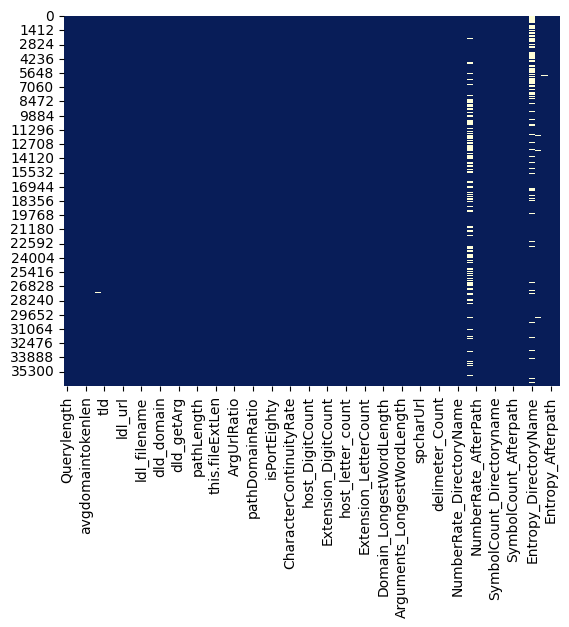

In [10]:
# Visualizing the missing values present in the dataset
sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu_r');

In [11]:
# Finding the count of missing values
print(df.isnull().sum().to_string())

Querylength                            0
domain_token_count                     0
path_token_count                       0
avgdomaintokenlen                      0
longdomaintokenlen                     0
avgpathtokenlen                      280
tld                                    0
charcompvowels                         0
charcompace                            0
ldl_url                                0
ldl_domain                             0
ldl_path                               0
ldl_filename                           0
ldl_getArg                             0
dld_url                                0
dld_domain                             0
dld_path                               0
dld_filename                           0
dld_getArg                             0
urlLen                                 0
domainlength                           0
pathLength                             0
subDirLen                              0
fileNameLen                            0
this.fileExtLen 

#### Since there are quite a lot of missing values in our datse, we opt to inpute the missing values using KNNImputer

In [12]:
# Separating dataset into predictor(X) and target(y) variables
X = df.copy()
X.drop(['URL_Type_obf_Type'], axis=1, inplace=True)
y = df['URL_Type_obf_Type']

In [13]:
# Using Square Root Method to choose optimal value of n
n = round(sqrt(len(X)-10130))

In [14]:
# Creating an instance of KNNImputer
imputer = KNNImputer(n_neighbors=n, weights='distance')

In [15]:
# Imputing the missing values
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

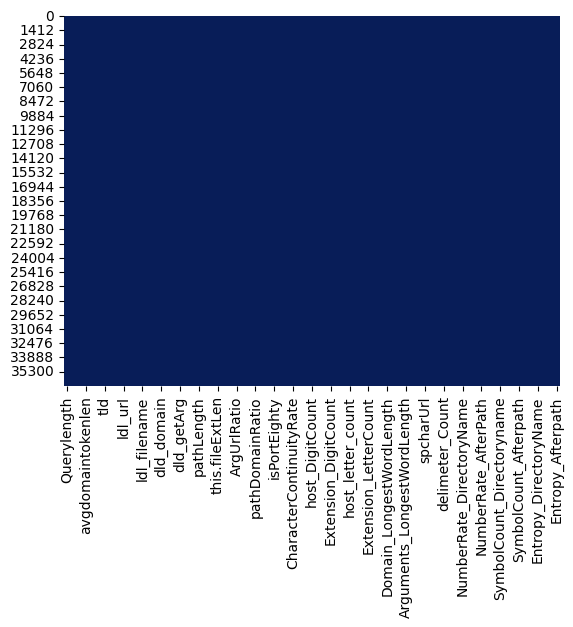

In [16]:
# Checking whether the missing values have been successfully imputed
sns.heatmap(X.isnull(), cbar=False, cmap='YlGnBu_r');

## Handling Class Imbalance

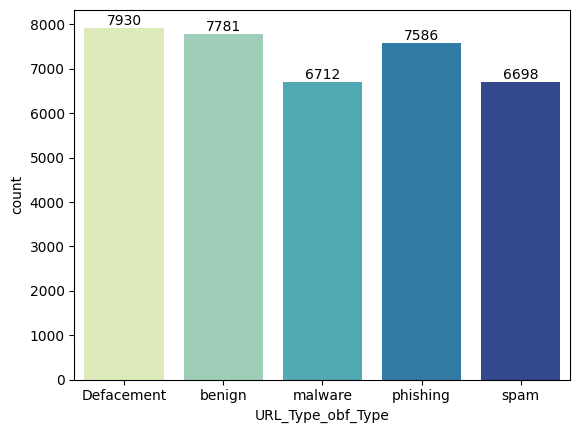

In [17]:
# Count of instances for each of the classes
ax = sns.countplot(x=y, palette='YlGnBu')
ax.bar_label(ax.containers[0]);

#### The classes seem to be pretty balanced, hence, we aren't going to use resampling techniques on our dataset.

## Feature Scaling

In [18]:
# Creating an instance of RobustScaler()
scaler = RobustScaler()

In [19]:
# Scaling the features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [20]:
# Displaying the first five records after feature scaling
X.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
0,0.0,1.0,-0.6,0.2,0.833333,0.175000,1.0,-0.416667,-0.714286,0.0,...,0.25,0.000000,0.0,0.0,0.052820,-0.572714,0.938808,0.391024,0.054983,0.0
1,0.0,1.0,-0.6,0.2,0.833333,0.975000,1.0,-0.083333,-0.571429,0.0,...,0.50,-0.166667,0.0,0.0,-0.550995,-0.572714,0.226189,0.446834,-0.802849,0.0
2,0.0,1.0,-0.6,0.2,0.833333,0.875000,1.0,-0.083333,-0.428571,0.0,...,0.50,-0.166667,0.0,0.0,-0.448161,-0.572714,0.226189,0.094966,-0.802849,0.0
3,0.0,1.0,0.8,0.2,0.833333,0.725000,1.0,1.583333,1.142857,0.0,...,0.50,-0.166667,0.0,0.0,-1.328606,-0.572714,0.226189,-0.747555,-0.802849,0.0
4,0.0,1.0,-0.4,0.2,0.833333,1.641667,1.0,0.416667,0.428571,0.0,...,0.50,-0.166667,0.0,0.0,-0.668468,-0.572714,0.226189,0.111044,-0.802849,0.0


## Feature Selection

In [21]:
# Creating an instance of SelectKBest feature selector to select best 25 features
select = SelectKBest(score_func=mutual_info_classif, k=25)

In [22]:
# Selecting the 25 best features based on the mutual information score
X = select.fit_transform(X,y)

In [23]:
# Displaying the records after feature selection
X

array([[ 2.00000000e-01,  1.75000000e-01, -4.18604651e-01, ...,
         3.91024412e-01,  5.49826191e-02,  0.00000000e+00],
       [ 2.00000000e-01,  9.75000000e-01, -2.32558140e-01, ...,
         4.46833890e-01, -8.02848947e-01,  0.00000000e+00],
       [ 2.00000000e-01,  8.75000000e-01, -2.55813953e-01, ...,
         9.49656506e-02, -8.02848947e-01,  0.00000000e+00],
       ...,
       [ 6.66666600e-01, -3.37500000e-01,  3.95348837e+00, ...,
        -4.41265200e-01, -1.31222127e-02,  9.69608084e-01],
       [-2.66666600e-01, -2.25000000e-01,  9.30232558e-01, ...,
        -2.44955173e-01,  3.27259742e-02,  1.01823911e+00],
       [ 6.66666600e-01, -4.00000000e-01,  3.51162791e+00, ...,
        -3.38336117e-01,  2.61778439e-03,  1.00599490e+00]])

## Initial Modeling - Base Models

In [24]:
# Encoding target attribute values using LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [25]:
# Displaying the records of y after encoding values
y

array([0, 0, 0, ..., 4, 4, 4])

In [26]:
# Splitting the dataset in a 80:20 train-test split ratio
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [27]:
# Creating an instance of the model
model = LogisticRegression(max_iter=2000)

In [28]:
# Fitting the model on the training set
model.fit(X_train,y_train)

LogisticRegression(max_iter=2000)

In [29]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [30]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1135   82   83  165  163]  |
|                   |  [  31 1297  116   70   12]  |
|                   |  [ 111  242  669  137  173]  |
|                   |  [ 106  102  127 1102   60]  |
|                   |  [ 128   19   94   85 1033]] |
|      Accuracy     |      0.7131571778806864      |
|     Precision     |      0.7131571778806864      |
|       Recall      |      0.7131571778806864      |
|      F1 Score     |      0.7131571778806864      |
+-------------------+------------------------------+


### Stochastic Gradient Descent Classifier

In [31]:
# Creating an instance of the model
model = SGDClassifier()

In [32]:
# Fitting the model on the training set
model.fit(X_train,y_train)

SGDClassifier()

In [33]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [34]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1116  128   23  211  150]  |
|                   |  [  35 1357   38   59   37]  |
|                   |  [ 222  330  368  211  201]  |
|                   |  [  77  133   60 1156   71]  |
|                   |  [ 178   22   98   90  971]] |
|      Accuracy     |      0.6766548624353037      |
|     Precision     |      0.6766548624353037      |
|       Recall      |      0.6766548624353037      |
|      F1 Score     |      0.6766548624353037      |
+-------------------+------------------------------+


### Perceptron

In [35]:
# Creating an instance of the model
model = Perceptron()

In [36]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Perceptron()

In [37]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [38]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1048  137   98  105  240]  |
|                   |  [  30  943  455   75   23]  |
|                   |  [  48  283  664   82  255]  |
|                   |  [ 506  106  246  593   46]  |
|                   |  [ 133    6  102   47 1071]] |
|      Accuracy     |      0.5882593298828657      |
|     Precision     |      0.5882593298828657      |
|       Recall      |      0.5882593298828657      |
|      F1 Score     |      0.5882593298828657      |
+-------------------+------------------------------+


### Naive Bayes Classifier

In [39]:
# Creating an instance of the model
model = GaussianNB()

In [40]:
# Fitting the model on the training set
model.fit(X_train,y_train)

GaussianNB()

In [41]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [42]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1083   86   86  315   58]  |
|                   |  [  92 1077  232   93   32]  |
|                   |  [ 214  295  647  156   20]  |
|                   |  [  63  112  229 1057   36]  |
|                   |  [ 501    3  292  264  299]] |
|      Accuracy     |      0.5670117134295832      |
|     Precision     |      0.5670117134295832      |
|       Recall      |      0.5670117134295832      |
|      F1 Score     |      0.5670117134295832      |
+-------------------+------------------------------+


### Decision Tree

In [43]:
# Creating an instance of the model
model = DecisionTreeClassifier()

In [44]:
# Fitting the model on the training set
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [45]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [46]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1564    7    9   39    9]  |
|                   |  [   8 1469   18   30    1]  |
|                   |  [   5    8 1291   21    7]  |
|                   |  [  61   54   57 1295   30]  |
|                   |  [  16    1    9   25 1308]] |
|      Accuracy     |      0.9434758921274857      |
|     Precision     |      0.9434758921274857      |
|       Recall      |      0.9434758921274857      |
|      F1 Score     |      0.9434758921274857      |
+-------------------+------------------------------+


### Histogram-based Gradient Boosting Classification Tree

In [47]:
# Creating an instance of the model
model = HistGradientBoostingClassifier()

In [48]:
# Fitting the model on the training set
model.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [49]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [50]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1616    0    1   11    0]  |
|                   |  [   0 1502   13   11    0]  |
|                   |  [   0    3 1301   24    4]  |
|                   |  [   9   33   12 1432   11]  |
|                   |  [   4    0    0    9 1346]] |
|      Accuracy     |      0.9802506129120131      |
|     Precision     |      0.9802506129120131      |
|       Recall      |      0.9802506129120131      |
|      F1 Score     |      0.9802506129120131      |
+-------------------+------------------------------+


### Extra Trees Classifier

In [51]:
# Creating an instance of the model
model = ExtraTreesClassifier()

In [52]:
# Fitting the model on the training set
model.fit(X_train,y_train)

ExtraTreesClassifier()

In [53]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [54]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1586    5    2   34    1]  |
|                   |  [   1 1503    2   18    2]  |
|                   |  [   3    7 1300   22    0]  |
|                   |  [  13   44    4 1425   11]  |
|                   |  [  10    0    2   35 1312]] |
|      Accuracy     |      0.9705802233723781      |
|     Precision     |      0.9705802233723781      |
|       Recall      |      0.9705802233723781      |
|      F1 Score     |      0.9705802233723781      |
+-------------------+------------------------------+


### Random Forest

In [55]:
# Creating an instance of the model
model = RandomForestClassifier()

In [56]:
# Fitting the model on the training set
model.fit(X_train,y_train)

RandomForestClassifier()

In [57]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [58]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1587    7    0   31    3]  |
|                   |  [   2 1500    6   16    2]  |
|                   |  [   2    7 1297   21    5]  |
|                   |  [  17   41    5 1428    6]  |
|                   |  [   9    2    2   31 1315]] |
|      Accuracy     |      0.9707164260419504      |
|     Precision     |      0.9707164260419504      |
|       Recall      |      0.9707164260419504      |
|      F1 Score     |      0.9707164260419504      |
+-------------------+------------------------------+


### XGBoost

In [59]:
# Creating an instance of the model
model = XGBClassifier()

In [60]:
# Fitting the model on the training set
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [61]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [62]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1606    2    0   20    0]  |
|                   |  [   0 1502    8   15    1]  |
|                   |  [   0    2 1305   24    1]  |
|                   |  [  13   32   16 1425   11]  |
|                   |  [   8    0    1    8 1342]] |
|      Accuracy     |      0.9779351675292836      |
|     Precision     |      0.9779351675292836      |
|       Recall      |      0.9779351675292836      |
|      F1 Score     |      0.9779351675292836      |
+-------------------+------------------------------+


### Multi-layer Perceptron

In [63]:
# Creating an instance of the model
model = MLPClassifier(max_iter=1000)

In [64]:
# Fitting the model on the training set
model.fit(X_train,y_train)

MLPClassifier(max_iter=1000)

In [65]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [66]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1545   12   13   50    8]  |
|                   |  [   2 1466   27   28    3]  |
|                   |  [   2    4 1290   31    5]  |
|                   |  [  38   45   38 1348   28]  |
|                   |  [   6    0    6   24 1323]] |
|      Accuracy     |      0.9496050122582402      |
|     Precision     |      0.9496050122582402      |
|       Recall      |      0.9496050122582402      |
|      F1 Score     |      0.9496050122582402      |
+-------------------+------------------------------+


### TabNet: Attentive Interpretable Tabular Learning

In [67]:
# Creating an instance of the model
model = TabNetClassifier()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [68]:
# Fitting the model on the training set
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.456   |  0:00:01s
epoch 1  | loss: 1.04036 |  0:00:03s
epoch 2  | loss: 0.88345 |  0:00:04s
epoch 3  | loss: 0.805   |  0:00:05s
epoch 4  | loss: 0.74754 |  0:00:07s
epoch 5  | loss: 0.69268 |  0:00:08s
epoch 6  | loss: 0.6525  |  0:00:10s
epoch 7  | loss: 0.63922 |  0:00:12s
epoch 8  | loss: 0.60491 |  0:00:14s
epoch 9  | loss: 0.58106 |  0:00:15s
epoch 10 | loss: 0.57969 |  0:00:16s
epoch 11 | loss: 0.55168 |  0:00:18s
epoch 12 | loss: 0.5408  |  0:00:19s
epoch 13 | loss: 0.54145 |  0:00:20s
epoch 14 | loss: 0.52627 |  0:00:22s
epoch 15 | loss: 0.5325  |  0:00:23s
epoch 16 | loss: 0.49473 |  0:00:25s
epoch 17 | loss: 0.47448 |  0:00:27s
epoch 18 | loss: 0.47011 |  0:00:29s
epoch 19 | loss: 0.46082 |  0:00:30s
epoch 20 | loss: 0.45048 |  0:00:31s
epoch 21 | loss: 0.44697 |  0:00:33s
epoch 22 | loss: 0.45152 |  0:00:34s
epoch 23 | loss: 0.43357 |  0:00:35s
epoch 24 | loss: 0.41706 |  0:00:37s
epoch 25 | loss: 0.42407 |  0:00:38s
epoch 26 | loss: 0.42296 |  0:00:40s
e

In [69]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [70]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1498   17   15   82   16]  |
|                   |  [   9 1442   40   27    8]  |
|                   |  [  14   21 1254   38    5]  |
|                   |  [  63   54   70 1278   32]  |
|                   |  [  20    2   12   37 1288]] |
|      Accuracy     |      0.9207300463089076      |
|     Precision     |      0.9207300463089076      |
|       Recall      |      0.9207300463089076      |
|      F1 Score     |      0.9207300463089076      |
+-------------------+------------------------------+


### CatBoost

In [71]:
# Creating an instance of the model
model = CatBoostClassifier()

In [72]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Learning rate set to 0.094012
0:	learn: 1.4644165	total: 162ms	remaining: 2m 41s
1:	learn: 1.3515612	total: 263ms	remaining: 2m 11s
2:	learn: 1.2688062	total: 356ms	remaining: 1m 58s
3:	learn: 1.2019321	total: 449ms	remaining: 1m 51s
4:	learn: 1.1394998	total: 562ms	remaining: 1m 51s
5:	learn: 1.0885706	total: 663ms	remaining: 1m 49s
6:	learn: 1.0488657	total: 760ms	remaining: 1m 47s
7:	learn: 1.0067703	total: 883ms	remaining: 1m 49s
8:	learn: 0.9652017	total: 996ms	remaining: 1m 49s
9:	learn: 0.9280755	total: 1.1s	remaining: 1m 48s
10:	learn: 0.9009216	total: 1.21s	remaining: 1m 48s
11:	learn: 0.8720517	total: 1.31s	remaining: 1m 47s
12:	learn: 0.8480087	total: 1.4s	remaining: 1m 46s
13:	learn: 0.8225206	total: 1.52s	remaining: 1m 47s
14:	learn: 0.8002440	total: 1.61s	remaining: 1m 45s
15:	learn: 0.7782511	total: 1.71s	remaining: 1m 45s
16:	learn: 0.7532227	total: 1.82s	remaining: 1m 45s
17:	learn: 0.7346436	total: 1.92s	remaining: 1m 44s
18:	learn: 0.7151983	total: 2.02s	remaining: 1

In [73]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [74]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1598    3    2   25    0]  |
|                   |  [   1 1499   12   13    1]  |
|                   |  [   2    4 1284   38    4]  |
|                   |  [  16   37   14 1416   14]  |
|                   |  [   9    0    0   16 1334]] |
|      Accuracy     |      0.9712612367202397      |
|     Precision     |      0.9712612367202397      |
|       Recall      |      0.9712612367202397      |
|      F1 Score     |      0.9712612367202397      |
+-------------------+------------------------------+


## Implementing Stacking Classifier

### Combination 1: All Base Classifiers + Meta Classifier Histogram-based Gradient Boosting Classification Tree

In [75]:
# Creating the list of base classifiers
estimators = [ ('Logistic Regression', LogisticRegression(max_iter=1000)),
               ('Stochastic Gradient Descent Classifier', SGDClassifier()),
               ('Perceptron', Perceptron()),
               ('Gaussian Naive Bayes Classifier', GaussianNB()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('XGBoost', XGBClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('TabNet', TabNetClassifier()),
               ('CatBoost', CatBoostClassifier())
             ]

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [76]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = HistGradientBoostingClassifier())

In [77]:
# Fitting the model on the training set
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.456   |  0:00:01s
epoch 1  | loss: 1.04036 |  0:00:02s
epoch 2  | loss: 0.88345 |  0:00:04s
epoch 3  | loss: 0.805   |  0:00:05s
epoch 4  | loss: 0.74754 |  0:00:07s
epoch 5  | loss: 0.69268 |  0:00:09s
epoch 6  | loss: 0.6525  |  0:00:11s
epoch 7  | loss: 0.63922 |  0:00:12s
epoch 8  | loss: 0.60491 |  0:00:14s
epoch 9  | loss: 0.58106 |  0:00:15s
epoch 10 | loss: 0.57969 |  0:00:16s
epoch 11 | loss: 0.55168 |  0:00:18s
epoch 12 | loss: 0.5408  |  0:00:19s
epoch 13 | loss: 0.54145 |  0:00:21s
epoch 14 | loss: 0.52627 |  0:00:23s
epoch 15 | loss: 0.5325  |  0:00:25s
epoch 16 | loss: 0.49473 |  0:00:26s
epoch 17 | loss: 0.47448 |  0:00:27s
epoch 18 | loss: 0.47011 |  0:00:29s
epoch 19 | loss: 0.46082 |  0:00:30s
epoch 20 | loss: 0.45048 |  0:00:32s
epoch 21 | loss: 0.44697 |  0:00:33s
epoch 22 | loss: 0.45152 |  0:00:34s
epoch 23 | loss: 0.43357 |  0:00:36s
epoch 24 | loss: 0.41706 |  0:00:38s
epoch 25 | loss: 0.42407 |  0:00:40s
epoch 26 | loss: 0.42296 |  0:00:41s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.49902 |  0:00:01s
epoch 1  | loss: 1.03432 |  0:00:03s
epoch 2  | loss: 0.88299 |  0:00:04s
epoch 3  | loss: 0.80561 |  0:00:05s
epoch 4  | loss: 0.75467 |  0:00:06s
epoch 5  | loss: 0.74129 |  0:00:08s
epoch 6  | loss: 0.70266 |  0:00:09s
epoch 7  | loss: 0.66818 |  0:00:10s
epoch 8  | loss: 0.62785 |  0:00:11s
epoch 9  | loss: 0.63812 |  0:00:12s
epoch 10 | loss: 0.61777 |  0:00:13s
epoch 11 | loss: 0.58569 |  0:00:14s
epoch 12 | loss: 0.55917 |  0:00:16s
epoch 13 | loss: 0.5498  |  0:00:17s
epoch 14 | loss: 0.53942 |  0:00:19s
epoch 15 | loss: 0.52296 |  0:00:20s
epoch 16 | loss: 0.52911 |  0:00:21s
epoch 17 | loss: 0.49613 |  0:00:22s
epoch 18 | loss: 0.49219 |  0:00:23s
epoch 19 | loss: 0.47823 |  0:00:24s
epoch 20 | loss: 0.4632  |  0:00:25s
epoch 21 | loss: 0.45687 |  0:00:26s
epoch 22 | loss: 0.44577 |  0:00:27s
epoch 23 | loss: 0.44844 |  0:00:28s
epoch 24 | loss: 0.43412 |  0:00:30s
epoch 25 | loss: 0.42013 |  0:00:32s
epoch 26 | loss: 0.41854 |  0:00:33s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.55582 |  0:00:01s
epoch 1  | loss: 1.09392 |  0:00:02s
epoch 2  | loss: 0.9306  |  0:00:03s
epoch 3  | loss: 0.83495 |  0:00:04s
epoch 4  | loss: 0.75883 |  0:00:05s
epoch 5  | loss: 0.72085 |  0:00:06s
epoch 6  | loss: 0.68664 |  0:00:07s
epoch 7  | loss: 0.63399 |  0:00:09s
epoch 8  | loss: 0.60682 |  0:00:11s
epoch 9  | loss: 0.57692 |  0:00:12s
epoch 10 | loss: 0.58035 |  0:00:13s
epoch 11 | loss: 0.56471 |  0:00:14s
epoch 12 | loss: 0.55965 |  0:00:15s
epoch 13 | loss: 0.54405 |  0:00:16s
epoch 14 | loss: 0.51821 |  0:00:17s
epoch 15 | loss: 0.51308 |  0:00:18s
epoch 16 | loss: 0.48953 |  0:00:19s
epoch 17 | loss: 0.48871 |  0:00:20s
epoch 18 | loss: 0.48086 |  0:00:22s
epoch 19 | loss: 0.48623 |  0:00:23s
epoch 20 | loss: 0.47327 |  0:00:25s
epoch 21 | loss: 0.45468 |  0:00:26s
epoch 22 | loss: 0.43722 |  0:00:27s
epoch 23 | loss: 0.44884 |  0:00:28s
epoch 24 | loss: 0.44638 |  0:00:29s
epoch 25 | loss: 0.42839 |  0:00:30s
epoch 26 | loss: 0.42737 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52427 |  0:00:01s
epoch 1  | loss: 1.09456 |  0:00:02s
epoch 2  | loss: 0.93602 |  0:00:04s
epoch 3  | loss: 0.87446 |  0:00:05s
epoch 4  | loss: 0.8229  |  0:00:06s
epoch 5  | loss: 0.77623 |  0:00:07s
epoch 6  | loss: 0.72302 |  0:00:09s
epoch 7  | loss: 0.68336 |  0:00:10s
epoch 8  | loss: 0.66804 |  0:00:11s
epoch 9  | loss: 0.6538  |  0:00:12s
epoch 10 | loss: 0.62804 |  0:00:13s
epoch 11 | loss: 0.61292 |  0:00:14s
epoch 12 | loss: 0.58925 |  0:00:15s
epoch 13 | loss: 0.57304 |  0:00:17s
epoch 14 | loss: 0.5609  |  0:00:18s
epoch 15 | loss: 0.54028 |  0:00:20s
epoch 16 | loss: 0.53313 |  0:00:21s
epoch 17 | loss: 0.50895 |  0:00:22s
epoch 18 | loss: 0.50443 |  0:00:23s
epoch 19 | loss: 0.48173 |  0:00:24s
epoch 20 | loss: 0.48818 |  0:00:25s
epoch 21 | loss: 0.48044 |  0:00:26s
epoch 22 | loss: 0.47024 |  0:00:27s
epoch 23 | loss: 0.467   |  0:00:29s
epoch 24 | loss: 0.45354 |  0:00:30s
epoch 25 | loss: 0.45342 |  0:00:32s
epoch 26 | loss: 0.44141 |  0:00:33s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.54068 |  0:00:01s
epoch 1  | loss: 1.07757 |  0:00:02s
epoch 2  | loss: 0.91548 |  0:00:03s
epoch 3  | loss: 0.81642 |  0:00:04s
epoch 4  | loss: 0.74069 |  0:00:05s
epoch 5  | loss: 0.71487 |  0:00:06s
epoch 6  | loss: 0.66188 |  0:00:08s
epoch 7  | loss: 0.65224 |  0:00:09s
epoch 8  | loss: 0.59577 |  0:00:11s
epoch 9  | loss: 0.58282 |  0:00:12s
epoch 10 | loss: 0.58711 |  0:00:13s
epoch 11 | loss: 0.56126 |  0:00:14s
epoch 12 | loss: 0.53596 |  0:00:15s
epoch 13 | loss: 0.51013 |  0:00:16s
epoch 14 | loss: 0.49943 |  0:00:17s
epoch 15 | loss: 0.50983 |  0:00:18s
epoch 16 | loss: 0.49371 |  0:00:20s
epoch 17 | loss: 0.48359 |  0:00:21s
epoch 18 | loss: 0.46529 |  0:00:22s
epoch 19 | loss: 0.46565 |  0:00:24s
epoch 20 | loss: 0.46514 |  0:00:25s
epoch 21 | loss: 0.44605 |  0:00:27s
epoch 22 | loss: 0.50076 |  0:00:28s
epoch 23 | loss: 0.48197 |  0:00:29s
epoch 24 | loss: 0.44981 |  0:00:30s
epoch 25 | loss: 0.43576 |  0:00:31s
epoch 26 | loss: 0.44868 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 249ms	remaining: 49.5s
5:	learn: 1.0976505	total: 291ms	remaining: 48.2s
6:	learn: 1.0581450	total: 337ms	remaining: 47.8s
7:	learn: 1.0158385	total: 387ms	remaining: 48s
8:	learn: 0.9859794	total: 435ms	remaining: 47.9s
9:	learn: 0.9495144	total: 479ms	remaining: 47.4s
10:	learn: 0.9163135	total: 524ms	remaining: 47.1s
11:	learn: 0.8843763	total: 565ms	remaining: 46.5s
12:	learn: 0.8566376	total: 609ms	remaining: 46.2s
13:	learn: 0.8333409	total: 656ms	remaining: 46.2s
14:	learn: 0.8090915	total: 703ms	remaining: 46.1s
15:	learn: 0.7820960	total: 749ms	remaining: 46s
16:	learn: 0.7571332	total: 794ms	remaining: 45.9s
17:	learn: 0.7421469	total: 835ms	remaining: 45.6s
18:	learn: 0.7221127	total: 888ms	remaining: 45.9s
19:	learn: 0.7056078	total: 930ms	remaining: 45.6s
20:	learn: 0.6902728	total: 972ms	remaining: 45.3s
21:	learn: 0.6751617	total: 1.01s	remaining: 45.1s
22:	learn: 0.6620602	total: 1.06s	remaini

StackingClassifier(estimators=[('Logistic Regression',
                                LogisticRegression(max_iter=1000)),
                               ('Stochastic Gradient Descent Classifier',
                                SGDClassifier()),
                               ('Perceptron', Perceptron()),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Random Forest', RandomForestClassifier()),...
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},
                                                 mask_type='sparsemax',
                                                 input_dim=None,
                                                 output_dim=None,
                                                 device_name='auto',
                                                 n_shared_decoder=1,
                                                 n_indep_decoder=1,
                                                 grouped_features=[])),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c296a1d0>)],
                   final_estimator=HistGradientBoostingClassifier())

In [78]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [79]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1604    0    0   23    1]  |
|                   |  [   0 1507    1   16    2]  |
|                   |  [   0    2 1304   26    0]  |
|                   |  [  15   26    0 1446   10]  |
|                   |  [   6    0    0   12 1341]] |
|      Accuracy     |      0.9809316262598747      |
|     Precision     |      0.9809316262598747      |
|       Recall      |      0.9809316262598747      |
|      F1 Score     |      0.9809316262598747      |
+-------------------+------------------------------+


### Combination 2: Seven Best Base Classifiers + Meta Classifier Histogram-based Gradient Boosting Classification Tree

In [80]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('TabNet', TabNetClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('XGBoost', XGBClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('CatBoost', CatBoostClassifier())
             ]

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [81]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = HistGradientBoostingClassifier())

In [82]:
# Fitting the model on the training set
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.456   |  0:00:01s
epoch 1  | loss: 1.04036 |  0:00:02s
epoch 2  | loss: 0.88345 |  0:00:04s
epoch 3  | loss: 0.805   |  0:00:05s
epoch 4  | loss: 0.74754 |  0:00:08s
epoch 5  | loss: 0.69268 |  0:00:09s
epoch 6  | loss: 0.6525  |  0:00:11s
epoch 7  | loss: 0.63922 |  0:00:12s
epoch 8  | loss: 0.60491 |  0:00:14s
epoch 9  | loss: 0.58106 |  0:00:15s
epoch 10 | loss: 0.57969 |  0:00:16s
epoch 11 | loss: 0.55168 |  0:00:18s
epoch 12 | loss: 0.5408  |  0:00:19s
epoch 13 | loss: 0.54145 |  0:00:21s
epoch 14 | loss: 0.52627 |  0:00:23s
epoch 15 | loss: 0.5325  |  0:00:25s
epoch 16 | loss: 0.49473 |  0:00:26s
epoch 17 | loss: 0.47448 |  0:00:28s
epoch 18 | loss: 0.47011 |  0:00:29s
epoch 19 | loss: 0.46082 |  0:00:30s
epoch 20 | loss: 0.45048 |  0:00:32s
epoch 21 | loss: 0.44697 |  0:00:33s
epoch 22 | loss: 0.45152 |  0:00:35s
epoch 23 | loss: 0.43357 |  0:00:37s
epoch 24 | loss: 0.41706 |  0:00:39s
epoch 25 | loss: 0.42407 |  0:00:40s
epoch 26 | loss: 0.42296 |  0:00:42s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.49902 |  0:00:01s
epoch 1  | loss: 1.03432 |  0:00:02s
epoch 2  | loss: 0.88299 |  0:00:03s
epoch 3  | loss: 0.80561 |  0:00:04s
epoch 4  | loss: 0.75467 |  0:00:05s
epoch 5  | loss: 0.74129 |  0:00:06s
epoch 6  | loss: 0.70266 |  0:00:07s
epoch 7  | loss: 0.66818 |  0:00:08s
epoch 8  | loss: 0.62785 |  0:00:10s
epoch 9  | loss: 0.63812 |  0:00:11s
epoch 10 | loss: 0.61777 |  0:00:13s
epoch 11 | loss: 0.58569 |  0:00:14s
epoch 12 | loss: 0.55917 |  0:00:15s
epoch 13 | loss: 0.5498  |  0:00:16s
epoch 14 | loss: 0.53942 |  0:00:17s
epoch 15 | loss: 0.52296 |  0:00:19s
epoch 16 | loss: 0.52911 |  0:00:20s
epoch 17 | loss: 0.49613 |  0:00:21s
epoch 18 | loss: 0.49219 |  0:00:22s
epoch 19 | loss: 0.47823 |  0:00:23s
epoch 20 | loss: 0.4632  |  0:00:24s
epoch 21 | loss: 0.45687 |  0:00:26s
epoch 22 | loss: 0.44577 |  0:00:27s
epoch 23 | loss: 0.44844 |  0:00:29s
epoch 24 | loss: 0.43412 |  0:00:30s
epoch 25 | loss: 0.42013 |  0:00:31s
epoch 26 | loss: 0.41854 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.55582 |  0:00:01s
epoch 1  | loss: 1.09392 |  0:00:02s
epoch 2  | loss: 0.9306  |  0:00:03s
epoch 3  | loss: 0.83495 |  0:00:05s
epoch 4  | loss: 0.75883 |  0:00:07s
epoch 5  | loss: 0.72085 |  0:00:08s
epoch 6  | loss: 0.68664 |  0:00:09s
epoch 7  | loss: 0.63399 |  0:00:10s
epoch 8  | loss: 0.60682 |  0:00:11s
epoch 9  | loss: 0.57692 |  0:00:12s
epoch 10 | loss: 0.58035 |  0:00:13s
epoch 11 | loss: 0.56471 |  0:00:14s
epoch 12 | loss: 0.55965 |  0:00:15s
epoch 13 | loss: 0.54405 |  0:00:16s
epoch 14 | loss: 0.51821 |  0:00:18s
epoch 15 | loss: 0.51308 |  0:00:20s
epoch 16 | loss: 0.48953 |  0:00:21s
epoch 17 | loss: 0.48871 |  0:00:22s
epoch 18 | loss: 0.48086 |  0:00:23s
epoch 19 | loss: 0.48623 |  0:00:25s
epoch 20 | loss: 0.47327 |  0:00:26s
epoch 21 | loss: 0.45468 |  0:00:27s
epoch 22 | loss: 0.43722 |  0:00:28s
epoch 23 | loss: 0.44884 |  0:00:29s
epoch 24 | loss: 0.44638 |  0:00:30s
epoch 25 | loss: 0.42839 |  0:00:31s
epoch 26 | loss: 0.42737 |  0:00:33s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52427 |  0:00:01s
epoch 1  | loss: 1.09456 |  0:00:02s
epoch 2  | loss: 0.93602 |  0:00:03s
epoch 3  | loss: 0.87446 |  0:00:04s
epoch 4  | loss: 0.8229  |  0:00:05s
epoch 5  | loss: 0.77623 |  0:00:06s
epoch 6  | loss: 0.72302 |  0:00:07s
epoch 7  | loss: 0.68336 |  0:00:09s
epoch 8  | loss: 0.66804 |  0:00:10s
epoch 9  | loss: 0.6538  |  0:00:12s
epoch 10 | loss: 0.62804 |  0:00:13s
epoch 11 | loss: 0.61292 |  0:00:14s
epoch 12 | loss: 0.58925 |  0:00:15s
epoch 13 | loss: 0.57304 |  0:00:16s
epoch 14 | loss: 0.5609  |  0:00:17s
epoch 15 | loss: 0.54028 |  0:00:18s
epoch 16 | loss: 0.53313 |  0:00:19s
epoch 17 | loss: 0.50895 |  0:00:20s
epoch 18 | loss: 0.50443 |  0:00:22s
epoch 19 | loss: 0.48173 |  0:00:23s
epoch 20 | loss: 0.48818 |  0:00:25s
epoch 21 | loss: 0.48044 |  0:00:26s
epoch 22 | loss: 0.47024 |  0:00:27s
epoch 23 | loss: 0.467   |  0:00:28s
epoch 24 | loss: 0.45354 |  0:00:30s
epoch 25 | loss: 0.45342 |  0:00:31s
epoch 26 | loss: 0.44141 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.54068 |  0:00:01s
epoch 1  | loss: 1.07757 |  0:00:02s
epoch 2  | loss: 0.91548 |  0:00:04s
epoch 3  | loss: 0.81642 |  0:00:05s
epoch 4  | loss: 0.74069 |  0:00:06s
epoch 5  | loss: 0.71487 |  0:00:08s
epoch 6  | loss: 0.66188 |  0:00:09s
epoch 7  | loss: 0.65224 |  0:00:10s
epoch 8  | loss: 0.59577 |  0:00:11s
epoch 9  | loss: 0.58282 |  0:00:12s
epoch 10 | loss: 0.58711 |  0:00:13s
epoch 11 | loss: 0.56126 |  0:00:14s
epoch 12 | loss: 0.53596 |  0:00:15s
epoch 13 | loss: 0.51013 |  0:00:17s
epoch 14 | loss: 0.49943 |  0:00:19s
epoch 15 | loss: 0.50983 |  0:00:20s
epoch 16 | loss: 0.49371 |  0:00:21s
epoch 17 | loss: 0.48359 |  0:00:22s
epoch 18 | loss: 0.46529 |  0:00:23s
epoch 19 | loss: 0.46565 |  0:00:25s
epoch 20 | loss: 0.46514 |  0:00:26s
epoch 21 | loss: 0.44605 |  0:00:27s
epoch 22 | loss: 0.50076 |  0:00:28s
epoch 23 | loss: 0.48197 |  0:00:29s
epoch 24 | loss: 0.44981 |  0:00:31s
epoch 25 | loss: 0.43576 |  0:00:32s
epoch 26 | loss: 0.44868 |  0:00:34s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 445ms	remaining: 1m 28s
5:	learn: 1.0976505	total: 542ms	remaining: 1m 29s
6:	learn: 1.0581450	total: 633ms	remaining: 1m 29s
7:	learn: 1.0158385	total: 723ms	remaining: 1m 29s
8:	learn: 0.9859794	total: 825ms	remaining: 1m 30s
9:	learn: 0.9495144	total: 918ms	remaining: 1m 30s
10:	learn: 0.9163135	total: 1s	remaining: 1m 30s
11:	learn: 0.8843763	total: 1.1s	remaining: 1m 30s
12:	learn: 0.8566376	total: 1.19s	remaining: 1m 30s
13:	learn: 0.8333409	total: 1.29s	remaining: 1m 31s
14:	learn: 0.8090915	total: 1.37s	remaining: 1m 29s
15:	learn: 0.7820960	total: 1.45s	remaining: 1m 29s
16:	learn: 0.7571332	total: 1.55s	remaining: 1m 29s
17:	learn: 0.7421469	total: 1.64s	remaining: 1m 29s
18:	learn: 0.7221127	total: 1.73s	remaining: 1m 29s
19:	learn: 0.7056078	total: 1.82s	remaining: 1m 29s
20:	learn: 0.6902728	total: 1.9s	remaining: 1m 28s
21:	learn: 0.6751617	total: 1.98s	remaining: 1m 27s
22:	learn: 0.6620602	tot

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('TabNet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=1,
                                                 optimizer_fn=<class 'torch....
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('Multi-layer Perceptron',
                                MLPClassifier(max_iter=1000)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c2a1a800>)],
                   final_estimator=HistGradientBoostingClassifier())

In [83]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [84]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1605    2    0   20    1]  |
|                   |  [   2 1506    1   16    1]  |
|                   |  [   0    2 1302   27    1]  |
|                   |  [  11   26    4 1445   11]  |
|                   |  [   3    0    0    8 1348]] |
|      Accuracy     |      0.981476436938164       |
|     Precision     |      0.981476436938164       |
|       Recall      |      0.981476436938164       |
|      F1 Score     |      0.981476436938164       |
+-------------------+------------------------------+


### Combination 3: Five Best Base Classifiers + Meta Classifier Histogram-based Gradient Boosting Classification Tree

In [85]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('XGBoost', XGBClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('CatBoost', CatBoostClassifier())
             ]

In [86]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = HistGradientBoostingClassifier())

In [87]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 237ms	remaining: 47.2s
5:	learn: 1.0976505	total: 280ms	remaining: 46.4s
6:	learn: 1.0581450	total: 324ms	remaining: 46s
7:	learn: 1.0158385	total: 371ms	remaining: 46s
8:	learn: 0.9859794	total: 417ms	remaining: 46s
9:	learn: 0.9495144	total: 465ms	remaining: 46s
10:	learn: 0.9163135	total: 508ms	remaining: 45.7s
11:	learn: 0.8843763	total: 551ms	remaining: 45.4s
12:	learn: 0.8566376	total: 596ms	remaining: 45.3s
13:	learn: 0.8333409	total: 653ms	remaining: 46s
14:	learn: 0.8090915	total: 702ms	remaining: 46.1s
15:	learn: 0.7820960	total: 750ms	remaining: 46.2s
16:	learn: 0.7571332	total: 806ms	remaining: 46.6s
17:	learn: 0.7421469	total: 852ms	remaining: 46.5s
18:	learn: 0.7221127	total: 902ms	remaining: 46.6s
19:	learn: 0.7056078	total: 950ms	remaining: 46.5s
20:	learn: 0.6902728	total: 993ms	remaining: 46.3s
21:	learn: 0.6751617	total: 1.04s	remaining: 46.1s
22:	learn: 0.6620602	total: 1.08s	remaining: 45

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Random Forest', RandomForestClassifier()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_type...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('Multi-layer Perceptron',
                                MLPClassifier(max_iter=1000)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c298e6b0>)],
                   final_estimator=HistGradientBoostingClassifier())

In [88]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [89]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1606    0    0   20    2]  |
|                   |  [   0 1505    1   19    1]  |
|                   |  [   0    3 1306   22    1]  |
|                   |  [  12   29    3 1437   16]  |
|                   |  [   3    0    0    8 1348]] |
|      Accuracy     |      0.9809316262598747      |
|     Precision     |      0.9809316262598747      |
|       Recall      |      0.9809316262598747      |
|      F1 Score     |      0.9809316262598747      |
+-------------------+------------------------------+


### Combination 4: Three Best Base Classifiers + Meta Classifier Histogram-based Gradient Boosting Classification Tree

In [90]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('XGBoost', XGBClassifier()),
               ('CatBoost', CatBoostClassifier())
             ]

In [91]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = HistGradientBoostingClassifier())

In [92]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 234ms	remaining: 46.6s
5:	learn: 1.0976505	total: 277ms	remaining: 45.9s
6:	learn: 1.0581450	total: 326ms	remaining: 46.3s
7:	learn: 1.0158385	total: 372ms	remaining: 46.1s
8:	learn: 0.9859794	total: 415ms	remaining: 45.7s
9:	learn: 0.9495144	total: 463ms	remaining: 45.9s
10:	learn: 0.9163135	total: 506ms	remaining: 45.5s
11:	learn: 0.8843763	total: 548ms	remaining: 45.1s
12:	learn: 0.8566376	total: 592ms	remaining: 44.9s
13:	learn: 0.8333409	total: 640ms	remaining: 45.1s
14:	learn: 0.8090915	total: 692ms	remaining: 45.4s
15:	learn: 0.7820960	total: 739ms	remaining: 45.4s
16:	learn: 0.7571332	total: 786ms	remaining: 45.4s
17:	learn: 0.7421469	total: 829ms	remaining: 45.2s
18:	learn: 0.7221127	total: 881ms	remaining: 45.5s
19:	learn: 0.7056078	total: 937ms	remaining: 45.9s
20:	learn: 0.6902728	total: 979ms	remaining: 45.7s
21:	learn: 0.6751617	total: 1.02s	remaining: 45.5s
22:	learn: 0.6620602	total: 1.06s	rem

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importa...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c497b4c0>)],
                   final_estimator=HistGradientBoostingClassifier())

In [93]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [94]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1606    0    0   20    2]  |
|                   |  [   0 1503    2   20    1]  |
|                   |  [   0    5 1298   26    3]  |
|                   |  [  12   29    3 1439   14]  |
|                   |  [   4    0    0   14 1341]] |
|      Accuracy     |      0.9788885862162898      |
|     Precision     |      0.9788885862162898      |
|       Recall      |      0.9788885862162898      |
|      F1 Score     |      0.9788885862162898      |
+-------------------+------------------------------+


### Combination 5: All Base Classifiers + Meta Classifier XGBoost

In [95]:
# Creating the list of base classifiers
estimators = [ ('Logistic Regression', LogisticRegression(max_iter=1000)),
               ('Stochastic Gradient Descent Classifier', SGDClassifier()),
               ('Perceptron', Perceptron()),
               ('Gaussian Naive Bayes Classifier', GaussianNB()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('Histogram-based Gradient Boosting Classification Tree', HistGradientBoostingClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('TabNet', TabNetClassifier()),
               ('CatBoost', CatBoostClassifier())
             ]

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [96]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier())

In [97]:
# Fitting the model on the training set
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.456   |  0:00:02s
epoch 1  | loss: 1.04036 |  0:00:03s
epoch 2  | loss: 0.88345 |  0:00:05s
epoch 3  | loss: 0.805   |  0:00:06s
epoch 4  | loss: 0.74754 |  0:00:07s
epoch 5  | loss: 0.69268 |  0:00:09s
epoch 6  | loss: 0.6525  |  0:00:10s
epoch 7  | loss: 0.63922 |  0:00:12s
epoch 8  | loss: 0.60491 |  0:00:13s
epoch 9  | loss: 0.58106 |  0:00:16s
epoch 10 | loss: 0.57969 |  0:00:17s
epoch 11 | loss: 0.55168 |  0:00:19s
epoch 12 | loss: 0.5408  |  0:00:20s
epoch 13 | loss: 0.54145 |  0:00:22s
epoch 14 | loss: 0.52627 |  0:00:23s
epoch 15 | loss: 0.5325  |  0:00:25s
epoch 16 | loss: 0.49473 |  0:00:26s
epoch 17 | loss: 0.47448 |  0:00:28s
epoch 18 | loss: 0.47011 |  0:00:30s
epoch 19 | loss: 0.46082 |  0:00:32s
epoch 20 | loss: 0.45048 |  0:00:33s
epoch 21 | loss: 0.44697 |  0:00:35s
epoch 22 | loss: 0.45152 |  0:00:36s
epoch 23 | loss: 0.43357 |  0:00:37s
epoch 24 | loss: 0.41706 |  0:00:39s
epoch 25 | loss: 0.42407 |  0:00:40s
epoch 26 | loss: 0.42296 |  0:00:42s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.49902 |  0:00:01s
epoch 1  | loss: 1.03432 |  0:00:02s
epoch 2  | loss: 0.88299 |  0:00:03s
epoch 3  | loss: 0.80561 |  0:00:04s
epoch 4  | loss: 0.75467 |  0:00:05s
epoch 5  | loss: 0.74129 |  0:00:06s
epoch 6  | loss: 0.70266 |  0:00:08s
epoch 7  | loss: 0.66818 |  0:00:10s
epoch 8  | loss: 0.62785 |  0:00:11s
epoch 9  | loss: 0.63812 |  0:00:12s
epoch 10 | loss: 0.61777 |  0:00:13s
epoch 11 | loss: 0.58569 |  0:00:14s
epoch 12 | loss: 0.55917 |  0:00:15s
epoch 13 | loss: 0.5498  |  0:00:16s
epoch 14 | loss: 0.53942 |  0:00:18s
epoch 15 | loss: 0.52296 |  0:00:19s
epoch 16 | loss: 0.52911 |  0:00:20s
epoch 17 | loss: 0.49613 |  0:00:22s
epoch 18 | loss: 0.49219 |  0:00:23s
epoch 19 | loss: 0.47823 |  0:00:25s
epoch 20 | loss: 0.4632  |  0:00:26s
epoch 21 | loss: 0.45687 |  0:00:27s
epoch 22 | loss: 0.44577 |  0:00:28s
epoch 23 | loss: 0.44844 |  0:00:29s
epoch 24 | loss: 0.43412 |  0:00:30s
epoch 25 | loss: 0.42013 |  0:00:31s
epoch 26 | loss: 0.41854 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.55582 |  0:00:01s
epoch 1  | loss: 1.09392 |  0:00:02s
epoch 2  | loss: 0.9306  |  0:00:03s
epoch 3  | loss: 0.83495 |  0:00:04s
epoch 4  | loss: 0.75883 |  0:00:05s
epoch 5  | loss: 0.72085 |  0:00:06s
epoch 6  | loss: 0.68664 |  0:00:07s
epoch 7  | loss: 0.63399 |  0:00:08s
epoch 8  | loss: 0.60682 |  0:00:10s
epoch 9  | loss: 0.57692 |  0:00:11s
epoch 10 | loss: 0.58035 |  0:00:13s
epoch 11 | loss: 0.56471 |  0:00:14s
epoch 12 | loss: 0.55965 |  0:00:15s
epoch 13 | loss: 0.54405 |  0:00:17s
epoch 14 | loss: 0.51821 |  0:00:18s
epoch 15 | loss: 0.51308 |  0:00:19s
epoch 16 | loss: 0.48953 |  0:00:20s
epoch 17 | loss: 0.48871 |  0:00:21s
epoch 18 | loss: 0.48086 |  0:00:22s
epoch 19 | loss: 0.48623 |  0:00:23s
epoch 20 | loss: 0.47327 |  0:00:25s
epoch 21 | loss: 0.45468 |  0:00:26s
epoch 22 | loss: 0.43722 |  0:00:28s
epoch 23 | loss: 0.44884 |  0:00:29s
epoch 24 | loss: 0.44638 |  0:00:30s
epoch 25 | loss: 0.42839 |  0:00:31s
epoch 26 | loss: 0.42737 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52427 |  0:00:01s
epoch 1  | loss: 1.09456 |  0:00:02s
epoch 2  | loss: 0.93602 |  0:00:04s
epoch 3  | loss: 0.87446 |  0:00:05s
epoch 4  | loss: 0.8229  |  0:00:06s
epoch 5  | loss: 0.77623 |  0:00:08s
epoch 6  | loss: 0.72302 |  0:00:09s
epoch 7  | loss: 0.68336 |  0:00:10s
epoch 8  | loss: 0.66804 |  0:00:11s
epoch 9  | loss: 0.6538  |  0:00:12s
epoch 10 | loss: 0.62804 |  0:00:13s
epoch 11 | loss: 0.61292 |  0:00:14s
epoch 12 | loss: 0.58925 |  0:00:16s
epoch 13 | loss: 0.57304 |  0:00:17s
epoch 14 | loss: 0.5609  |  0:00:19s
epoch 15 | loss: 0.54028 |  0:00:20s
epoch 16 | loss: 0.53313 |  0:00:21s
epoch 17 | loss: 0.50895 |  0:00:22s
epoch 18 | loss: 0.50443 |  0:00:23s
epoch 19 | loss: 0.48173 |  0:00:24s
epoch 20 | loss: 0.48818 |  0:00:26s
epoch 21 | loss: 0.48044 |  0:00:27s
epoch 22 | loss: 0.47024 |  0:00:28s
epoch 23 | loss: 0.467   |  0:00:29s
epoch 24 | loss: 0.45354 |  0:00:30s
epoch 25 | loss: 0.45342 |  0:00:32s
epoch 26 | loss: 0.44141 |  0:00:34s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.54068 |  0:00:01s
epoch 1  | loss: 1.07757 |  0:00:02s
epoch 2  | loss: 0.91548 |  0:00:03s
epoch 3  | loss: 0.81642 |  0:00:04s
epoch 4  | loss: 0.74069 |  0:00:06s
epoch 5  | loss: 0.71487 |  0:00:08s
epoch 6  | loss: 0.66188 |  0:00:09s
epoch 7  | loss: 0.65224 |  0:00:10s
epoch 8  | loss: 0.59577 |  0:00:12s
epoch 9  | loss: 0.58282 |  0:00:13s
epoch 10 | loss: 0.58711 |  0:00:14s
epoch 11 | loss: 0.56126 |  0:00:15s
epoch 12 | loss: 0.53596 |  0:00:16s
epoch 13 | loss: 0.51013 |  0:00:17s
epoch 14 | loss: 0.49943 |  0:00:18s
epoch 15 | loss: 0.50983 |  0:00:20s
epoch 16 | loss: 0.49371 |  0:00:21s
epoch 17 | loss: 0.48359 |  0:00:23s
epoch 18 | loss: 0.46529 |  0:00:24s
epoch 19 | loss: 0.46565 |  0:00:25s
epoch 20 | loss: 0.46514 |  0:00:27s
epoch 21 | loss: 0.44605 |  0:00:28s
epoch 22 | loss: 0.50076 |  0:00:29s
epoch 23 | loss: 0.48197 |  0:00:30s
epoch 24 | loss: 0.44981 |  0:00:31s
epoch 25 | loss: 0.43576 |  0:00:32s
epoch 26 | loss: 0.44868 |  0:00:33s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 435ms	remaining: 1m 26s
5:	learn: 1.0976505	total: 526ms	remaining: 1m 27s
6:	learn: 1.0581450	total: 596ms	remaining: 1m 24s
7:	learn: 1.0158385	total: 691ms	remaining: 1m 25s
8:	learn: 0.9859794	total: 783ms	remaining: 1m 26s
9:	learn: 0.9495144	total: 871ms	remaining: 1m 26s
10:	learn: 0.9163135	total: 962ms	remaining: 1m 26s
11:	learn: 0.8843763	total: 1.06s	remaining: 1m 27s
12:	learn: 0.8566376	total: 1.15s	remaining: 1m 27s
13:	learn: 0.8333409	total: 1.24s	remaining: 1m 27s
14:	learn: 0.8090915	total: 1.33s	remaining: 1m 27s
15:	learn: 0.7820960	total: 1.42s	remaining: 1m 27s
16:	learn: 0.7571332	total: 1.52s	remaining: 1m 27s
17:	learn: 0.7421469	total: 1.61s	remaining: 1m 27s
18:	learn: 0.7221127	total: 1.7s	remaining: 1m 27s
19:	learn: 0.7056078	total: 1.79s	remaining: 1m 27s
20:	learn: 0.6902728	total: 1.89s	remaining: 1m 27s
21:	learn: 0.6751617	total: 1.97s	remaining: 1m 27s
22:	learn: 0.6620602

StackingClassifier(estimators=[('Logistic Regression',
                                LogisticRegression(max_iter=1000)),
                               ('Stochastic Gradient Descent Classifier',
                                SGDClassifier()),
                               ('Perceptron', Perceptron()),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Random Forest', RandomForestClassifier()),...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [98]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [99]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1613    0    0   13    2]  |
|                   |  [   0 1507    1   17    1]  |
|                   |  [   0    3 1302   26    1]  |
|                   |  [   8   29    2 1445   13]  |
|                   |  [   2    0    0   10 1347]] |
|      Accuracy     |      0.9825660582947425      |
|     Precision     |      0.9825660582947425      |
|       Recall      |      0.9825660582947425      |
|      F1 Score     |      0.9825660582947425      |
+-------------------+------------------------------+


### Combination 6: Seven Best Base Classifiers + Meta Classifier XGBoost

In [100]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('TabNet', TabNetClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('Histogram-based Gradient Boosting Classification Tree', HistGradientBoostingClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('CatBoost', CatBoostClassifier())
             ]

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [101]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier())

In [102]:
# Fitting the model on the training set
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.456   |  0:00:02s
epoch 1  | loss: 1.04036 |  0:00:04s
epoch 2  | loss: 0.88345 |  0:00:05s
epoch 3  | loss: 0.805   |  0:00:07s
epoch 4  | loss: 0.74754 |  0:00:08s
epoch 5  | loss: 0.69268 |  0:00:09s
epoch 6  | loss: 0.6525  |  0:00:11s
epoch 7  | loss: 0.63922 |  0:00:12s
epoch 8  | loss: 0.60491 |  0:00:14s
epoch 9  | loss: 0.58106 |  0:00:16s
epoch 10 | loss: 0.57969 |  0:00:18s
epoch 11 | loss: 0.55168 |  0:00:19s
epoch 12 | loss: 0.5408  |  0:00:21s
epoch 13 | loss: 0.54145 |  0:00:22s
epoch 14 | loss: 0.52627 |  0:00:23s
epoch 15 | loss: 0.5325  |  0:00:25s
epoch 16 | loss: 0.49473 |  0:00:26s
epoch 17 | loss: 0.47448 |  0:00:28s
epoch 18 | loss: 0.47011 |  0:00:30s
epoch 19 | loss: 0.46082 |  0:00:32s
epoch 20 | loss: 0.45048 |  0:00:33s
epoch 21 | loss: 0.44697 |  0:00:35s
epoch 22 | loss: 0.45152 |  0:00:36s
epoch 23 | loss: 0.43357 |  0:00:38s
epoch 24 | loss: 0.41706 |  0:00:39s
epoch 25 | loss: 0.42407 |  0:00:41s
epoch 26 | loss: 0.42296 |  0:00:42s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.49902 |  0:00:01s
epoch 1  | loss: 1.03432 |  0:00:02s
epoch 2  | loss: 0.88299 |  0:00:04s
epoch 3  | loss: 0.80561 |  0:00:05s
epoch 4  | loss: 0.75467 |  0:00:06s
epoch 5  | loss: 0.74129 |  0:00:07s
epoch 6  | loss: 0.70266 |  0:00:08s
epoch 7  | loss: 0.66818 |  0:00:09s
epoch 8  | loss: 0.62785 |  0:00:10s
epoch 9  | loss: 0.63812 |  0:00:12s
epoch 10 | loss: 0.61777 |  0:00:13s
epoch 11 | loss: 0.58569 |  0:00:15s
epoch 12 | loss: 0.55917 |  0:00:16s
epoch 13 | loss: 0.5498  |  0:00:17s
epoch 14 | loss: 0.53942 |  0:00:18s
epoch 15 | loss: 0.52296 |  0:00:20s
epoch 16 | loss: 0.52911 |  0:00:21s
epoch 17 | loss: 0.49613 |  0:00:22s
epoch 18 | loss: 0.49219 |  0:00:23s
epoch 19 | loss: 0.47823 |  0:00:24s
epoch 20 | loss: 0.4632  |  0:00:25s
epoch 21 | loss: 0.45687 |  0:00:26s
epoch 22 | loss: 0.44577 |  0:00:28s
epoch 23 | loss: 0.44844 |  0:00:29s
epoch 24 | loss: 0.43412 |  0:00:31s
epoch 25 | loss: 0.42013 |  0:00:32s
epoch 26 | loss: 0.41854 |  0:00:33s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.55582 |  0:00:01s
epoch 1  | loss: 1.09392 |  0:00:02s
epoch 2  | loss: 0.9306  |  0:00:03s
epoch 3  | loss: 0.83495 |  0:00:04s
epoch 4  | loss: 0.75883 |  0:00:06s
epoch 5  | loss: 0.72085 |  0:00:08s
epoch 6  | loss: 0.68664 |  0:00:09s
epoch 7  | loss: 0.63399 |  0:00:10s
epoch 8  | loss: 0.60682 |  0:00:11s
epoch 9  | loss: 0.57692 |  0:00:12s
epoch 10 | loss: 0.58035 |  0:00:13s
epoch 11 | loss: 0.56471 |  0:00:14s
epoch 12 | loss: 0.55965 |  0:00:15s
epoch 13 | loss: 0.54405 |  0:00:16s
epoch 14 | loss: 0.51821 |  0:00:17s
epoch 15 | loss: 0.51308 |  0:00:19s
epoch 16 | loss: 0.48953 |  0:00:21s
epoch 17 | loss: 0.48871 |  0:00:22s
epoch 18 | loss: 0.48086 |  0:00:23s
epoch 19 | loss: 0.48623 |  0:00:24s
epoch 20 | loss: 0.47327 |  0:00:25s
epoch 21 | loss: 0.45468 |  0:00:26s
epoch 22 | loss: 0.43722 |  0:00:28s
epoch 23 | loss: 0.44884 |  0:00:29s
epoch 24 | loss: 0.44638 |  0:00:30s
epoch 25 | loss: 0.42839 |  0:00:31s
epoch 26 | loss: 0.42737 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52427 |  0:00:01s
epoch 1  | loss: 1.09456 |  0:00:02s
epoch 2  | loss: 0.93602 |  0:00:03s
epoch 3  | loss: 0.87446 |  0:00:04s
epoch 4  | loss: 0.8229  |  0:00:05s
epoch 5  | loss: 0.77623 |  0:00:06s
epoch 6  | loss: 0.72302 |  0:00:07s
epoch 7  | loss: 0.68336 |  0:00:08s
epoch 8  | loss: 0.66804 |  0:00:10s
epoch 9  | loss: 0.6538  |  0:00:12s
epoch 10 | loss: 0.62804 |  0:00:13s
epoch 11 | loss: 0.61292 |  0:00:14s
epoch 12 | loss: 0.58925 |  0:00:15s
epoch 13 | loss: 0.57304 |  0:00:16s
epoch 14 | loss: 0.5609  |  0:00:17s
epoch 15 | loss: 0.54028 |  0:00:19s
epoch 16 | loss: 0.53313 |  0:00:20s
epoch 17 | loss: 0.50895 |  0:00:21s
epoch 18 | loss: 0.50443 |  0:00:22s
epoch 19 | loss: 0.48173 |  0:00:23s
epoch 20 | loss: 0.48818 |  0:00:25s
epoch 21 | loss: 0.48044 |  0:00:27s
epoch 22 | loss: 0.47024 |  0:00:28s
epoch 23 | loss: 0.467   |  0:00:29s
epoch 24 | loss: 0.45354 |  0:00:30s
epoch 25 | loss: 0.45342 |  0:00:31s
epoch 26 | loss: 0.44141 |  0:00:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.54068 |  0:00:01s
epoch 1  | loss: 1.07757 |  0:00:03s
epoch 2  | loss: 0.91548 |  0:00:04s
epoch 3  | loss: 0.81642 |  0:00:06s
epoch 4  | loss: 0.74069 |  0:00:07s
epoch 5  | loss: 0.71487 |  0:00:08s
epoch 6  | loss: 0.66188 |  0:00:09s
epoch 7  | loss: 0.65224 |  0:00:10s
epoch 8  | loss: 0.59577 |  0:00:11s
epoch 9  | loss: 0.58282 |  0:00:12s
epoch 10 | loss: 0.58711 |  0:00:13s
epoch 11 | loss: 0.56126 |  0:00:15s
epoch 12 | loss: 0.53596 |  0:00:16s
epoch 13 | loss: 0.51013 |  0:00:18s
epoch 14 | loss: 0.49943 |  0:00:19s
epoch 15 | loss: 0.50983 |  0:00:21s
epoch 16 | loss: 0.49371 |  0:00:22s
epoch 17 | loss: 0.48359 |  0:00:23s
epoch 18 | loss: 0.46529 |  0:00:24s
epoch 19 | loss: 0.46565 |  0:00:25s
epoch 20 | loss: 0.46514 |  0:00:26s
epoch 21 | loss: 0.44605 |  0:00:27s
epoch 22 | loss: 0.50076 |  0:00:28s
epoch 23 | loss: 0.48197 |  0:00:30s
epoch 24 | loss: 0.44981 |  0:00:31s
epoch 25 | loss: 0.43576 |  0:00:33s
epoch 26 | loss: 0.44868 |  0:00:35s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 237ms	remaining: 47.2s
5:	learn: 1.0976505	total: 293ms	remaining: 48.5s
6:	learn: 1.0581450	total: 336ms	remaining: 47.7s
7:	learn: 1.0158385	total: 383ms	remaining: 47.5s
8:	learn: 0.9859794	total: 429ms	remaining: 47.3s
9:	learn: 0.9495144	total: 480ms	remaining: 47.5s
10:	learn: 0.9163135	total: 523ms	remaining: 47s
11:	learn: 0.8843763	total: 572ms	remaining: 47.1s
12:	learn: 0.8566376	total: 615ms	remaining: 46.7s
13:	learn: 0.8333409	total: 658ms	remaining: 46.4s
14:	learn: 0.8090915	total: 708ms	remaining: 46.5s
15:	learn: 0.7820960	total: 755ms	remaining: 46.4s
16:	learn: 0.7571332	total: 801ms	remaining: 46.3s
17:	learn: 0.7421469	total: 843ms	remaining: 46s
18:	learn: 0.7221127	total: 887ms	remaining: 45.8s
19:	learn: 0.7056078	total: 942ms	remaining: 46.1s
20:	learn: 0.6902728	total: 984ms	remaining: 45.9s
21:	learn: 0.6751617	total: 1.03s	remaining: 45.6s
22:	learn: 0.6620602	total: 1.07s	remaini

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('TabNet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=1,
                                                 optimizer_fn=<class 'torch....
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [103]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [104]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1611    0    0   16    1]  |
|                   |  [   0 1503    3   19    1]  |
|                   |  [   0    4 1302   25    1]  |
|                   |  [   8   27    3 1450    9]  |
|                   |  [   2    0    0   16 1341]] |
|      Accuracy     |      0.9816126396077363      |
|     Precision     |      0.9816126396077363      |
|       Recall      |      0.9816126396077363      |
|      F1 Score     |      0.9816126396077363      |
+-------------------+------------------------------+


### Combination 7: Five Best Base Classifiers + Meta Classifier XGBoost

In [105]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Random Forest', RandomForestClassifier()),
               ('Histogram-based Gradient Boosting Classification Tree', HistGradientBoostingClassifier()),
               ('Multi-layer Perceptron', MLPClassifier(max_iter=1000)),
               ('CatBoost', CatBoostClassifier())
             ]

In [106]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier())

In [107]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 239ms	remaining: 47.5s
5:	learn: 1.0976505	total: 283ms	remaining: 46.9s
6:	learn: 1.0581450	total: 335ms	remaining: 47.5s
7:	learn: 1.0158385	total: 382ms	remaining: 47.3s
8:	learn: 0.9859794	total: 426ms	remaining: 46.9s
9:	learn: 0.9495144	total: 487ms	remaining: 48.2s
10:	learn: 0.9163135	total: 533ms	remaining: 47.9s
11:	learn: 0.8843763	total: 575ms	remaining: 47.4s
12:	learn: 0.8566376	total: 621ms	remaining: 47.1s
13:	learn: 0.8333409	total: 665ms	remaining: 46.8s
14:	learn: 0.8090915	total: 714ms	remaining: 46.9s
15:	learn: 0.7820960	total: 766ms	remaining: 47.1s
16:	learn: 0.7571332	total: 812ms	remaining: 46.9s
17:	learn: 0.7421469	total: 856ms	remaining: 46.7s
18:	learn: 0.7221127	total: 907ms	remaining: 46.8s
19:	learn: 0.7056078	total: 957ms	remaining: 46.9s
20:	learn: 0.6902728	total: 1000ms	remaining: 46.6s
21:	learn: 0.6751617	total: 1.04s	remaining: 46.4s
22:	learn: 0.6620602	total: 1.08s	re

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Random Forest', RandomForestClassifier()),
                               ('Histogram-based Gradient Boosting '
                                'Classification Tree',
                                HistGradientBoostingClassifier()),
                               ('Multi-layer Perceptron',
                                MLPClassifier(max_iter=1000)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c1171bd0>)],
                   final_estimato...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [108]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [109]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1606    1    0   20    1]  |
|                   |  [   0 1503    1   19    3]  |
|                   |  [   0    4 1308   20    0]  |
|                   |  [   9   31    4 1443   10]  |
|                   |  [   3    0    0    9 1347]] |
|      Accuracy     |      0.9816126396077363      |
|     Precision     |      0.9816126396077363      |
|       Recall      |      0.9816126396077363      |
|      F1 Score     |      0.9816126396077363      |
+-------------------+------------------------------+


### Combination 8: Three Best Base Classifiers + Meta Classifier XGBoost

In [110]:
# Creating the list of base classifiers
estimators = [ ('Extra Trees Classifier', ExtraTreesClassifier()),
               ('Histogram-based Gradient Boosting Classification Tree', HistGradientBoostingClassifier()),
               ('CatBoost', CatBoostClassifier())
             ]

In [111]:
# Creating an instance of the model
model = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier())

In [112]:
# Fitting the model on the training set
model.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
4:	learn: 1.1459645	total: 241ms	remaining: 48s
5:	learn: 1.0976505	total: 285ms	remaining: 47.2s
6:	learn: 1.0581450	total: 334ms	remaining: 47.3s
7:	learn: 1.0158385	total: 391ms	remaining: 48.5s
8:	learn: 0.9859794	total: 434ms	remaining: 47.8s
9:	learn: 0.9495144	total: 482ms	remaining: 47.7s
10:	learn: 0.9163135	total: 525ms	remaining: 47.2s
11:	learn: 0.8843763	total: 568ms	remaining: 46.7s
12:	learn: 0.8566376	total: 615ms	remaining: 46.7s
13:	learn: 0.8333409	total: 660ms	remaining: 46.5s
14:	learn: 0.8090915	total: 710ms	remaining: 46.6s
15:	learn: 0.7820960	total: 762ms	remaining: 46.9s
16:	learn: 0.7571332	total: 812ms	remaining: 46.9s
17:	learn: 0.7421469	total: 857ms	remaining: 46.8s
18:	learn: 0.7221127	total: 903ms	remaining: 46.6s
19:	learn: 0.7056078	total: 955ms	remaining: 46.8s
20:	learn: 0.6902728	total: 997ms	remaining: 46.5s
21:	learn: 0.6751617	total: 1.04s	remaining: 46.3s
22:	learn: 0.6620602	total: 1.08s	remai

StackingClassifier(estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier()),
                               ('Histogram-based Gradient Boosting '
                                'Classification Tree',
                                HistGradientBoostingClassifier()),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7fb6c0ffb6a0>)],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_byno...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [113]:
# Getting the model predictions
y_pred = model.predict(X_test)

In [114]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

table.add_row(["Confusion Matrix", confusion_matrix(y_test,y_pred)])

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+------------------------------+
| Evaluation Metric |            Value             |
+-------------------+------------------------------+
|  Confusion Matrix | [[1612    0    0   15    1]  |
|                   |  [   1 1504    1   19    1]  |
|                   |  [   0    2 1307   23    0]  |
|                   |  [   7   24    8 1448   10]  |
|                   |  [   3    0    0   17 1339]] |
|      Accuracy     |      0.9820212476164533      |
|     Precision     |      0.9820212476164533      |
|       Recall      |      0.9820212476164533      |
|      F1 Score     |      0.9820212476164533      |
+-------------------+------------------------------+
